# 1. libraries Import for Semantic Segmantation Skeliton 


In [4]:
import tensorflow as tf
import numpy as np
import os 
import shutil
import numpy as np 
import pandas as pd 
import imageio 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 2. Path to Dataset

In [1]:
path = '/Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/'
Name_of_TrainImages_folder = 'original_images'
Name_of_ImagesMask_folder = 'label_images_semantic'

# 3. Test Train split function

In [2]:
def train_test_splits(percentage,folder,target): #mask or image
    try:
        Images = []
        for count in os.listdir(path+folder):
            Images.append(count)
        Image_count = (len(Images))   
        Split_20_per = (Image_count/100)*int(percentage)
        percent_count = round(Split_20_per)
        for count_2 , filename in enumerate(os.listdir(path+folder)) :
            if  filename != '.DS_Store':
                if count_2 != int(percent_count):
                    #print(filename)
                    shutil.move(path+folder +'//'+filename,path+'//'+'test_data'+'//'+target)
                    print(filename)
                else:
                    break
    except Exception as e:
        print(e)
#train_test_splits(5,Name_of_ImagesMask_folder,'mask_test')  
#train_test_splits(5,Name_of_TrainImages_folder,'image_test') 

# 4. Data Loader and Basic operations

In [5]:
image_path = os.path.join(path,Name_of_TrainImages_folder +'//')
mask_path = os.path.join(path,Name_of_ImagesMask_folder +'//')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list if i != '.DS_Store']
mask_list = [mask_path+i for i in mask_list if i != '.DS_Store']
image_list = sorted(image_list)
mask_list = sorted(mask_list)

print("Total number of images is : {} ".format(len(image_list)))

print("Print and Varify first image from images folder :", image_list[0])
print("Print and Varify first image from images_mask folder :", mask_list[0])

Total number of images is : 376 
Print and Varify first image from images folder : /Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/original_images//041.jpg
Print and Varify first image from images_mask folder : /Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/label_images_semantic//041.png


# 5. Visualize some images :

(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Mask')

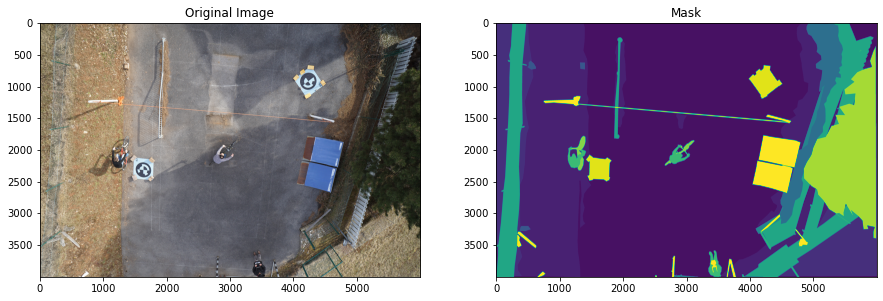

In [118]:
n = 10 # you can chose any index 
img  = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [119]:
image_list_dataset = tf.data.Dataset.list_files(image_list ,shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list , shuffle=False)
images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((images_filenames
                                              ,masks_filenames))
for image,mask in dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'/Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/original_images//000.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/shoeb.ahmad/Desktop/AI Hub/Jupyter Notebooks/Unet++/Satalite Aerial Images/Data/label_images_semantic//000.png', shape=(), dtype=string)


# 6. preprocessing our data

In [120]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask

image_ds = dataset.map(process_path) # apply the preprocces_path function to our dataset
print(image_ds)
processed_image_ds = image_ds.map(preprocess) # apply the preprocess function to our dataset

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


# 7.  Define The Conv Block For The Contracting Path


In [121]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# 8. Define the upsampling block for the expanding path

In [122]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

# 9. Finally! ,  we will Define the unet model 
## which composes of a set of conv blocks and upsampling blocks

In [123]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [124]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

# 10. Our model is ready !!

In [125]:
unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_120 (Conv2D)            (None, 96, 128, 32)  896         ['input_7[0][0]']                
                                                                                                  
 conv2d_121 (Conv2D)            (None, 96, 128, 32)  9248        ['conv2d_120[0][0]']             
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_121[0][0]']       

                                                                                                  
 conv2d_139 (Conv2D)            (None, 96, 128, 23)  759         ['conv2d_138[0][0]']             
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [126]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
EPOCHS = 110
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/110


2022-06-03 12:44:59.797089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 12:45:10.156691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 124 of 500
2022-06-03 12:45:20.012556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 279 of 500
2022-06-03 12:45:27.114792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


25/25 [==============================] - 31s 120ms/step - loss: 2.5695 - accuracy: 0.2971
Epoch 2/110
25/25 [==============================] - 3s 119ms/step - loss: 2.1861 - accuracy: 0.3763
Epoch 3/110
25/25 [==============================] - 3s 119ms/step - loss: 1.9709 - accuracy: 0.4359
Epoch 4/110
25/25 [==============================] - 3s 119ms/step - loss: 1.7456 - accuracy: 0.5159
Epoch 5/110
25/25 [==============================] - 3s 119ms/step - loss: 1.6396 - accuracy: 0.5385
Epoch 6/110
25/25 [==============================] - 3s 119ms/step - loss: 1.5265 - accuracy: 0.5552
Epoch 7/110
25/25 [==============================] - 3s 119ms/step - loss: 1.4342 - accuracy: 0.5747
Epoch 8/110
25/25 [==============================] - 3s 119ms/step - loss: 1.6108 - accuracy: 0.5359
Epoch 9/110
25/25 [==============================] - 3s 119ms/step - loss: 1.3716 - accuracy: 0.5966
Epoch 10/110
25/25 [==============================] - 3s 119ms/step - loss: 1.3001 - accuracy: 0.6142


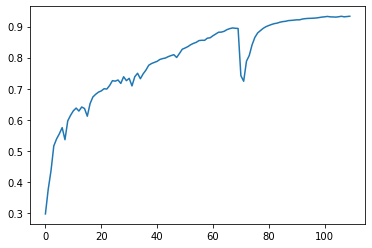

In [128]:
plt.plot(model_history.history["accuracy"])

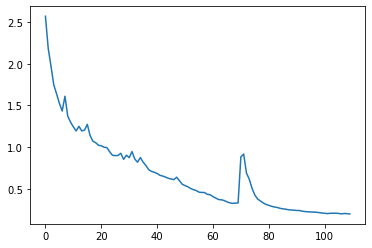

In [129]:
plt.plot(model_history.history["loss"])

In [130]:
training_loss, training_accuracy = unet.evaluate(train_dataset, batch_size = 16)

2022-06-03 12:51:01.841259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 41ms/step - loss: 0.1961 - accuracy: 0.9345


In [131]:
print(f'Model Accuracy on the Test Dataset: {round(training_accuracy * 100, 2)}%')

Model Accuracy on the Test Dataset: 93.45%


In [132]:
unet.save('Drone_Areal_Images_updated.h5')